<a href="https://colab.research.google.com/github/beamaia/steel-plates-arcelor/blob/main/notebooks/desafio_beatriz_maia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

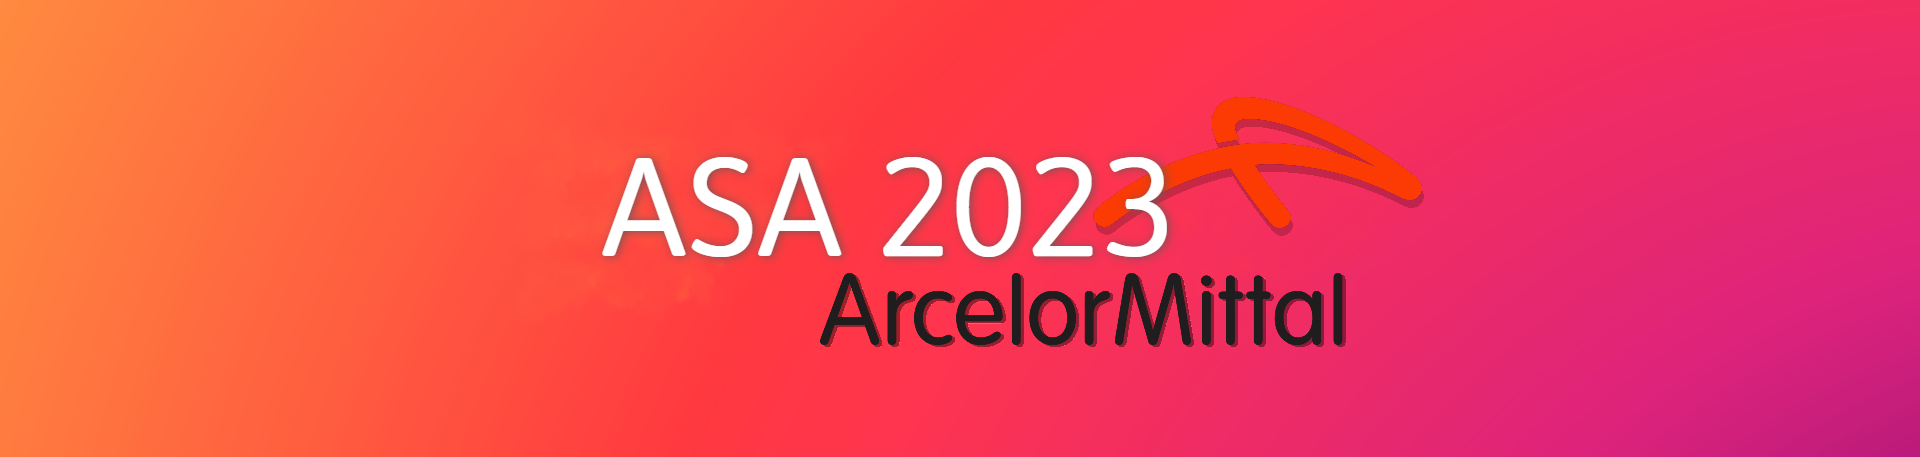

# Desafio ASA 2023 - Beatriz Maia



Este notebook possui uma análise exploratório de dados para um problema de placas de aços dentro do contexto da Arcelor Mittal para o desafio ASA 2023. Além do código e visualizações, este notebook terá comentários trazendo uma perspectiva mais narrativa do processo de pensamento que tive durante o problema.

## Descrição do problema

A ArcelorMittal está procurando formas de melhorar sua identificação de defeitos nas placas de aço. As placas são produzidas no lingotamento contínuo, após um processo de várias etapas que começa nos altos-fornos. Por causa da
complexidade do processo, diversos defeitos podem ocorrer na placa produzida. Nosso especialista gerou um conjunto de dados contendo dois defeitos que ele gostaria de distinguir com maior exatidão. Todos os dados foram obtidos a
partir de sensores automatizados ou imagens de câmeras, que identificam dimensões e características da placa e do defeito.
Você deve encontrar insights a partir dos dados e auxiliar o time de qualidade da ArcelorMittal a identificar se o defeito encontrado na placa é do tipo **0** ou do tipo **1**.

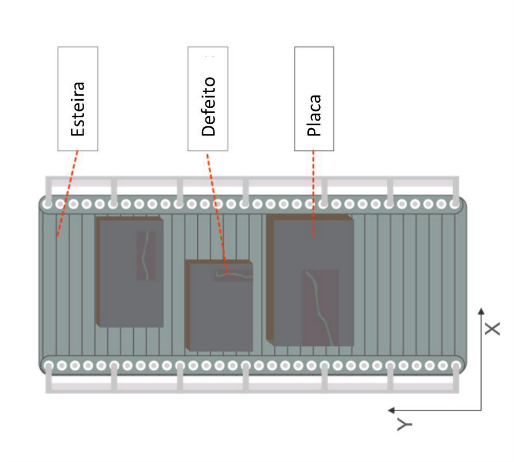

**Dicas**</br>
• Realizar a carga dos dados e analisar os tipos e características das colunas; </br>
• Realizar a análise exploratória para comunicar as informações relevantes encontradas sobre os dados (utilize
textos e gráficos); </br>
• Aplicar métodos de detecção de outliers; </br>
• Caso seja necessário para o tipo de modelo que você escolheu utilizar, realizar o pré-processamento, </br>
contendo tratamento de nulos, encoding e normalização, conforme visto no treinamento; </br>
• Realizar o treino do modelo utilizando validação cruzada (cross validation), justificando a escolha do modelo utilizado; </br>
• Calcular todas métricas de desempenho estudadas. Recomendamos utilizar o F1 como métrica principal. </br>
• Responder as perguntas propostas; </br>
• Anotar todas as suas descobertas e análises que podem contribuir para melhorar o desempenho do modelo e do processo de tomada de decisão </br>

***

## Imports e configurações

In [1]:
%pylab inline
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

from sklearn.impute import SimpleImputer
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sklearn.model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Modelos
import sklearn.linear_model
from sklearn.linear_model import LinearRegression

from random import seed

Populating the interactive namespace from numpy and matplotlib


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Leitura dos dados

In [5]:
DATA_PATH = r'drive/MyDrive/ASA 2023/Colab Notebooks/beatriz_maia/data/performance_corporal.csv'
DATA_DELIMITER = ','

In [6]:
raw_df = pd.read_csv(DATA_PATH, delimiter=DATA_DELIMITER)
raw_df.head(10)

FileNotFoundError: ignored

## Análise exploratório pre-transformação dos dados

## Transformações dos dados

## Treinamento dos modelos

## Análise dos resultados

## Perguntas